In [ ]:
print("Installing necessary libraries for fine-tuning and evaluation...")

!pip install -q transformers accelerate torch datasets peft trl openai scikit-learn gradio

print("Libraries installed successfully!")

Installing necessary libraries for fine-tuning and evaluation...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 127.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 

In [ ]:
import os
from huggingface_hub import login, notebook_login
print("Attempting Hugging Face login...")

notebook_login()
print("HF Login successful (or token already present)!")

Attempting Hugging Face login...


HF Login successful (or token already present)!


In [ ]:
import torch
import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    BitsAndBytesConfig,  # For quantization config
)
from datasets import load_dataset, Dataset, DatasetDict
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training  # PEFT tools
from trl import SFTTrainer  # The fine-tuning trainer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import json  # For OpenAI JSONL format
import time  # For waiting on OpenAI jobs
from IPython.display import display, Markdown
import random

print("Core libraries imported.")

# Check for GPU availability (Crucial for fine-tuning)
if torch.cuda.is_available():
    print(f"GPU detected: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU detected. Fine-tuning requires a GPU. Please enable GPU in Runtime settings.")
    # Optionally exit or raise an error here


Core libraries imported.
GPU detected: Tesla T4


In [ ]:
# Helper function for markdown display
def print_markdown(text):
    """Displays text as Markdown."""
    display(Markdown(text))

**PRACTICE OPPORTUNITY:**
- **Look at the previous cell output, is a GPU detected?**
- **Why is confirming GPU presence absolutely critical for this project compared to previous ones?**

# TASK 3: LOAD AND PREPARE THE FINANCIAL NEWS DATASETS


We'll load the `Daniel-ML/sentiment-analysis-for-financial-news-v2` dataset from the Hugging Face Hub. This dataset contains sentences from Financial News, with sentiments tagged.

**Steps:**
1.  Load the dataset using `load_dataset`.
2.  Inspect its structure and labels.
3.  Split the data into training and testing sets to evaluate our models fairly.


In [ ]:
# Link to the dataset on Hugging Face: https://huggingface.co/datasets/Daniel-ML/sentiment-analysis-for-financial-news-v2/viewer
dataset_id = "Daniel-ML/sentiment-analysis-for-financial-news-v2"

print(f"Loading dataset: {dataset_id}...")
labeled_dataset = load_dataset(dataset_id, split = "train")  
print("Dataset loaded successfully!")

print("\n--- Dataset Information ---")
print(labeled_dataset)


Loading dataset: Daniel-ML/sentiment-analysis-for-financial-news-v2...


README.md:   0%|          | 0.00/36.0 [00:00<?, ?B/s]

pd_df_json.json:   0%|          | 0.00/788k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

Dataset loaded successfully!

--- Dataset Information ---
Dataset({
    features: ['sentiment', 'text'],
    num_rows: 4846
})


In [ ]:

print("\n--- Dataset Features ---")
print(labeled_dataset.features)


--- Dataset Features ---
{'sentiment': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None)}


In [ ]:

labels = labeled_dataset.to_pandas()['sentiment'].unique().tolist()
print(f"Unique labels in the dataset: {labels}")


Unique labels in the dataset: ['neutral', 'negative', 'positive']


In [ ]:

display(labeled_dataset.select(range(5)).to_pandas()[["text", "sentiment"]])

,text,sentiment
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive


In [ ]:

print("\nSplitting data into Train (90%) and Test (10%)...")
train_test_split_ratio = 0.10
seed = 42  # for reproducibility

split_dataset = labeled_dataset.train_test_split(
    test_size = train_test_split_ratio, seed = seed, shuffle = True,
)
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print("\nTrain/Test Split Complete.")


Splitting data into Train (90%) and Test (10%)...
Training set size: 4361
Test set size: 485

Train/Test Split Complete.


In [ ]:

def format_for_sft_gemma(example, tokenizer):

    # Define the conversation structure
    system_prompt = "Classify the sentiment of the following sentence from News as positive, negative, or neutral."
    user_prompt = f"Sentence: {example['text']}"
    assistant_response = example['sentiment'] # The target label

    messages = [
        {"role": "user", "content": f"{system_prompt}\n{user_prompt}"}, # Combine system/user for simplicity here
        {"role": "assistant", "content": assistant_response}
    ]

    ion_prompt = False: means we’re NOT adding the assistant prompt to generate the response. We already provided the assistant's message
    formatted_text = tokenizer.apply_chat_template(messages, tokenize = False, add_generation_prompt = False)
    return {"text": formatted_text}

print("\nSupervised Fine Tuning (SFT) Trainer formatting function defined")



Supervised Fine Tuning (SFT) Trainer formatting function defined


In [ ]:

from tqdm.notebook import tqdm  # Progress bar meaning takadom "progress" in Arabic

os_model_id = "google/gemma-3-1b-it"

quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # Use 4-bit weights (saves lots of RAM)
    bnb_4bit_quant_type = "nf4", # nf4 is a better 4-bit format (Non-Float 4)
    bnb_4bit_compute_dtype = torch.float16 # Math is done in float16 for speed
)

base_os_tokenizer = AutoTokenizer.from_pretrained(os_model_id)


if base_os_tokenizer.pad_token is None:
    base_os_tokenizer.pad_token = base_os_tokenizer.eos_token
    print(f"Set pad_token to eos_token ({base_os_tokenizer.eos_token})")


In [ ]:



example = {
    "text": "The economy is showing signs of recovery after a tough year.",
    "sentiment": "positive"
}


formatted_example = format_for_sft_gemma(example, base_os_tokenizer)


print("\n--- Sample Formatted Prompt ---")
print(formatted_example["text"])


--- Sample Formatted Prompt ---
<bos><start_of_turn>user
Classify the sentiment of the following sentence from News as positive, negative, or neutral.
Sentence: The economy is showing signs of recovery after a tough year.<end_of_turn>
<start_of_turn>model
positive<end_of_turn>



In [ ]:
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    BitsAndBytesConfig,  # For quantization config
)
import torch
import transformers

In [ ]:
from tqdm.notebook import tqdm  # Progress bar

# Choose Model
os_model_id = "google/gemma-3-1b-it" # <-- UPDATED Model ID


# Load Base Model (Quantized)
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type = "nf4", # Recommended type
    bnb_4bit_compute_dtype = torch.float16
)

base_os_tokenizer = AutoTokenizer.from_pretrained(os_model_id)

# Set pad token if missing (Gemma often doesn't have one)
if base_os_tokenizer.pad_token is None:
    base_os_tokenizer.pad_token = base_os_tokenizer.eos_token
    print(f"Set pad_token to eos_token ({base_os_tokenizer.eos_token})")

# Load model
base_os_model = AutoModelForCausalLM.from_pretrained(
    os_model_id,
    quantization_config = quantization_config,
    torch_dtype = torch.float16,
    device_map = "auto",
)
# Ensure model pad token ID is updated if tokenizer's was
base_os_model.config.pad_token_id = base_os_tokenizer.pad_token_id
print("Base Gemma model and tokenizer loaded successfully.")



Base Gemma model and tokenizer loaded successfully.


In [ ]:
# Let's apply the SFT formatting function to our training and testing datasets
print("\nFormatting data for SFTTrainer (Gemma format)...")
sft_train_dataset = train_dataset.map(
              format_for_sft_gemma,
              fn_kwargs={"tokenizer": base_os_tokenizer},
              remove_columns=list(train_dataset.features)
              )
sft_test_dataset = test_dataset.map(
              format_for_sft_gemma,
              fn_kwargs={"tokenizer": base_os_tokenizer},
              remove_columns=list(test_dataset.features)
              )
print("SFTTrainer (Gemma) formatting complete.")
print("Sample SFT Gemma format:")
print(sft_train_dataset[0]['text'])


Formatting data for SFTTrainer (Gemma format)...
SFTTrainer (Gemma) formatting complete.
Sample SFT Gemma format:
<bos><start_of_turn>user
Classify the sentiment of the following sentence from News as positive, negative, or neutral.
Sentence: These module products will be available for trials during 3Q-07 and for volume deliveries during 4Q-07 .<end_of_turn>
<start_of_turn>model
neutral<end_of_turn>



In [ ]:
# Perform Zero-Shot Classification Prompt Function (Gemma)
def create_zeroshot_prompt_gemma(sentence, tokenizer):

    """Creates zero-shot prompt using Gemma chat template."""
    system_prompt = f"Classify the sentiment of the following sentence from Financial News. Respond with ONLY ONE of the following labels: {', '.join(labels)}."
    user_prompt = f"Sentence: {sentence}"
    messages = [
        {"role": "user", "content": f"{system_prompt}\n{user_prompt}"},
    ]
    # Apply template, add_generation_prompt=True adds the assistant turn marker
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return prompt


In [ ]:

def classify_zero_shot_os_gemma(sentence, model, tokenizer):

    prompt = create_zeroshot_prompt_gemma(sentence, tokenizer)
    inputs = tokenizer(prompt, return_tensors = "pt", truncation = True, max_length = 512).to(model.device)

    eos_id = tokenizer.eos_token_id          # eos_token_id: end of sentence
    pad_id = tokenizer.pad_token_id          # pad_token_id: padding token


    with torch.no_grad():

      outputs = model.generate(
          **inputs,
          max_new_tokens = 10, # Limits the number of tokens the model can generate
          eos_token_id = eos_id,
          pad_token_id = eos_id,
          do_sample = False
      )
    # Extracts and decode the generated text
    response_ids = outputs[0][inputs['input_ids'].shape[1]:]
    response_text = tokenizer.decode(response_ids, skip_special_tokens=True).strip()
    
    labels = ["neutral", "negative", "positive"]

    predicted_label = "Unknown"
    for label_text in labels:
        if label_text.lower() in response_text.lower(): # Simple check if label is present
              predicted_label = label_text
              break

    print(f"Predicted Label: {predicted_label}")
    return predicted_label


In [ ]:
true_labels = []

true_labels = [ex['sentiment'] for ex in test_dataset]
true_labels

['neutral',
 'negative',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'positive',
 'neutral',
 'positive',
 'neutral',
 'negative',
 'negative',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'positive',
 'negative',
 'neutral',
 'positive',
 'positive',
 'positive',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'negative',
 'neutral',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'positive',
 '

In [ ]:
base_os_predictions = [] 

for example in tqdm(test_dataset):
    predicted_label = classify_zero_shot_os_gemma(example['text'], base_os_model, base_os_tokenizer)
    base_os_predictions.append(predicted_label)


  0%|          | 0/485 [00:00<?, ?it/s]

Predicted Label: positive
Predicted Label: negative
Predicted Label: negative
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: neutral
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: neutral
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: neutral
Predicted Label: positive
Predicted Label: positive
Predicted Label: negative
Predicted Label: positive
Predicted Label: negative
Predicted Label: positive
Predicted Label: positive
Predicted Label: negative
Predicted Label: negative
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: negative
Predicted Label

In [ ]:
print("\n--- Base Gemma Model: Zero-Shot Evaluation Results ---")
valid_indices = [i for i, p in enumerate(base_os_predictions) if p not in ["Error", "Unknown"]]
filtered_preds = [base_os_predictions[i] for i in valid_indices]
filtered_true = [true_labels[i] for i in valid_indices]

accuracy = accuracy_score(filtered_true, filtered_preds)
report = classification_report(filtered_true, filtered_preds, labels=labels, zero_division=0, target_names=labels)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)


--- Base Gemma Model: Zero-Shot Evaluation Results ---
Accuracy: 0.4598

Classification Report:
              precision    recall  f1-score   support

     neutral       0.90      0.16      0.27       290
    negative       0.56      0.84      0.67        56
    positive       0.37      0.94      0.53       139

    accuracy                           0.46       485
   macro avg       0.61      0.64      0.49       485
weighted avg       0.71      0.46      0.39       485



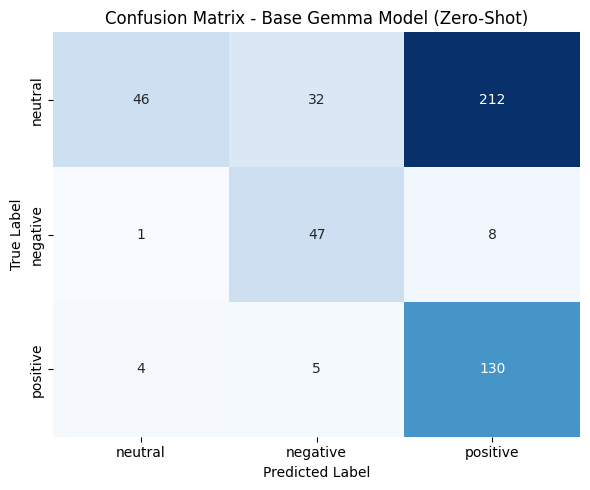

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(filtered_true, filtered_preds, labels=labels)

# Create heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Base Gemma Model (Zero-Shot)")
plt.tight_layout()
plt.show()

In [ ]:
print("\n--- Preparing Model and Config for PEFT/LoRA Fine-tuning ---")
base_os_model.gradient_checkpointing_enable()  
prepared_model = prepare_model_for_kbit_training(base_os_model)
print("Model prepared for k-bit training.")

print(prepared_model)

lora_config = LoraConfig(
    r = 16,  # LoRA rank (dimension of adapter matrices). Higher rank = more parameters, potentially better fit but slower. 8, 16, 32 are common.
    lora_alpha = 32,  # Scaling factor for LoRA weights (often 2*r).
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj"],  # Modules to apply LoRA to.
    lora_dropout = 0.05,  # Dropout probability for LoRA layers.
    bias = "none",  # Usually set to 'none'.
    task_type = "CAUSAL_LM",  # Task type for sequence generation.
)
print("LoRA Config created.")

peft_model = get_peft_model(prepared_model, lora_config)
print("PEFT model created.")
peft_model.print_trainable_parameters()  # See how few parameters we're actually training!



--- Preparing Model and Config for PEFT/LoRA Fine-tuning ---
Model prepared for k-bit training.
Gemma3ForCausalLM(
  (model): Gemma3TextModel(
    (embed_tokens): Gemma3TextScaledWordEmbedding(262144, 1152, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma3DecoderLayer(
        (self_attn): Gemma3Attention(
          (q_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=1152, out_features=1024, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=1152, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=1024, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Line

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [ ]:

output_dir = "./sentiment_finetuned_adapter"  # Directory to save adapter weights

training_args = TrainingArguments(
    output_dir = output_dir,
    per_device_train_batch_size = 4,  
    gradient_accumulation_steps = 2,  
    learning_rate = 2e-4,  
    num_train_epochs = 1,  
    logging_steps = 25,  
    save_strategy = "epoch",  
    fp16=not torch.cuda.is_bf16_supported(), 
    bf16 = torch.cuda.is_bf16_supported(),  
    max_grad_norm = 0.3,  
    warmup_ratio = 0.03,  
    lr_scheduler_type = "constant",  
    report_to = "none",  
)
print("Training Arguments set.")

trainer = SFTTrainer(
    model = peft_model,  # The PEFT model
    args = training_args,  # Training arguments
    train_dataset = sft_train_dataset,  # Formatted training data
    peft_config = lora_config,  # Pass the LoRA config again
)
print("SFTTrainer initialized.")

print("\n--- Starting Fine-tuning... ---")
try:
    training_results = trainer.train()
    print("--- Fine-tuning Complete! ---")
    print(training_results)

    print(f"Saving LoRA adapter model to {output_dir}...")
    trainer.save_model(output_dir)  # Saves only the adapter weights

    base_os_tokenizer.save_pretrained(output_dir)
    print("Adapter and tokenizer saved.")

    del trainer
    del peft_model  # Delete the model used for training
    
    torch.cuda.empty_cache()
    import gc

    gc.collect()
    print("Cleaned up training objects from memory.")

    fine_tuning_successful = True

except Exception as e:
    print(f"Error during fine-tuning: {e}")
    fine_tuning_successful = False



Training Arguments set.


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


SFTTrainer initialized.

--- Starting Fine-tuning... ---


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
25,3.534900
50,2.005200
75,1.737200
100,1.608500
125,1.617800
150,1.554100
175,1.537500
200,1.517100
225,1.530300
250,1.513100


--- Fine-tuning Complete! ---
TrainOutput(global_step=545, training_loss=1.6402256256943448, metrics={'train_runtime': 1230.902, 'train_samples_per_second': 3.543, 'train_steps_per_second': 0.443, 'total_flos': 1502407584930816.0, 'train_loss': 1.6402256256943448})
Saving LoRA adapter model to ./sentiment_finetuned_adapter...
Adapter and tokenizer saved.
Cleaned up training objects from memory.


In [ ]:
tuned_os_predictions = []

adapter_path = "./sentiment_finetuned_adapter"

print(f"\n--- Loading Fine-tuned Open Source Model from {adapter_path} ---")

tuned_os_tokenizer = AutoTokenizer.from_pretrained(adapter_path, trust_remote_code=True)

quantization_config = BitsAndBytesConfig(load_in_4bit=True)

base_model_reload = AutoModelForCausalLM.from_pretrained(
    os_model_id,  # The original base model ID
    quantization_config=quantization_config,
    device_map="auto",
    trust_remote_code=True,
)

if tuned_os_tokenizer.pad_token_id is not None:
    base_model_reload.config.pad_token_id = tuned_os_tokenizer.pad_token_id

from peft import PeftModel

tuned_os_model = PeftModel.from_pretrained(base_model_reload, adapter_path)
print("Loaded PEFT model (base + adapter).")

# Ensure model is in evaluation mode
tuned_os_model.eval()
print("Fine-tuned OS model loaded successfully.")

# Assuming true_labels list was populated in previous steps
if "true_labels" not in locals() or not true_labels:
    print("Warning: true_labels not found from previous steps. Re-extracting.")
    true_labels = [ex["sentiment"] for ex in test_dataset]

for example in tqdm(test_dataset):  # Use tqdm for progress bar
    sentence = example["text"]
    # Use the SAME zero-shot function, but pass the TUNED model
    predicted_label = classify_zero_shot_os_gemma(sentence, tuned_os_model, tuned_os_tokenizer)
    tuned_os_predictions.append(predicted_label)

print("\n--- Fine-Tuned Open Source Model: Evaluation Results ---")
valid_indices_tuned = [i for i, p in enumerate(tuned_os_predictions) if p not in ["Error", "Unknown"]]
filtered_preds_tuned = [tuned_os_predictions[i] for i in valid_indices_tuned]
# Ensure we use the same true labels corresponding to the test set order
filtered_true_tuned = [
    true_labels[i] for i in valid_indices_tuned
]  


accuracy_tuned = accuracy_score(filtered_true_tuned, filtered_preds_tuned)
report_tuned = classification_report(
    filtered_true_tuned, filtered_preds_tuned, labels=labels, zero_division=0
)

print(f"Accuracy: {accuracy_tuned:.4f}")
print("\nClassification Report:")
print(report_tuned)

print("\n--- Comparison with Base OS Model ---")

print(f"Base OS Accuracy:      {accuracy:.4f}")
print(f"Fine-Tuned OS Accuracy: {accuracy_tuned:.4f}")
improvement = accuracy_tuned - accuracy
print(f"Improvement:           {improvement:+.4f}")





--- Loading Fine-tuned Open Source Model from ./sentiment_finetuned_adapter ---
Loaded PEFT model (base + adapter).
Fine-tuned OS model loaded successfully.


  0%|          | 0/485 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `64` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Predicted Label: positive


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `64` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Predicted Label: negative
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: neutral
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: negative
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: neutral
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: neutral
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: positive
Predicted Label: negative
Predicted Label: positive
Predicted Label

In [ ]:
import seaborn as sns
sns.countplot(labeled_dataset["sentiment"])

In [ ]:

index = 5
train_dataset[index]['text']



In [ ]:

example = {
    "text": train_dataset[index]['text'],
    "sentiment": train_dataset[index]['sentiment']
}

formatted_example = format_for_sft_gemma(example, base_os_tokenizer)

print("\n--- Sample Formatted Prompt ---")
print(formatted_example["text"])

In [ ]:

os_model_id = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"

quantization_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type = "nf4", # Recommended type
    bnb_4bit_compute_dtype = torch.float16
)

base_os_tokenizer = AutoTokenizer.from_pretrained(os_model_id)

formatted_example = format_for_sft_gemma(example, base_os_tokenizer)

print("\n--- Sample Formatted Prompt ---")
print(formatted_example["text"])

In [ ]:
# Perform Zero-Shot Classification Prompt Function (Gemma)
def create_zeroshot_prompt_gemma(sentence, tokenizer):

    """Creates zero-shot prompt using Gemma chat template."""
    system_prompt = f"Classify the sentiment of the following sentence from Financial News."
    user_prompt = f"Sentence: {sentence}"
    messages = [
        {"role": "user", "content": f"{system_prompt}\n{user_prompt}"},
    ]
    # Apply template, add_generation_prompt=True adds the assistant turn marker
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return prompt


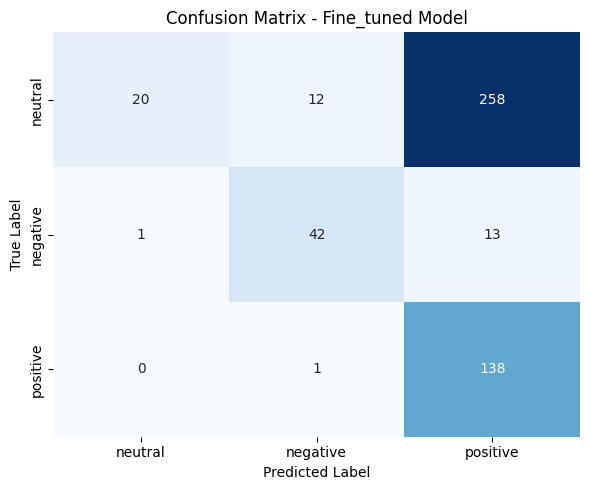

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(filtered_true_tuned, filtered_preds_tuned, labels=labels)

# Create heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Fine_tuned Model")
plt.tight_layout()
plt.show()
